# Homework 3
### Optimization via Stochastic Gradient Descent.
Here goes the text of the problem.

The following has been written by me during classes.

In [34]:
from utility import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [35]:
def plot_error(e, err, xlabel):
    """
    This function enables you to simply plot the error
    of the gradient descent with respect to the epoch e
    """

    plt.figure(figsize=(8, 4))
    plt.plot(e, err, 'r-')
    plt.xlabel(xlabel)
    plt.ylabel('Error (||\u2207ƒ||_2)')
    plt.title('Grad norm')
    plt.grid()
    plt.show()

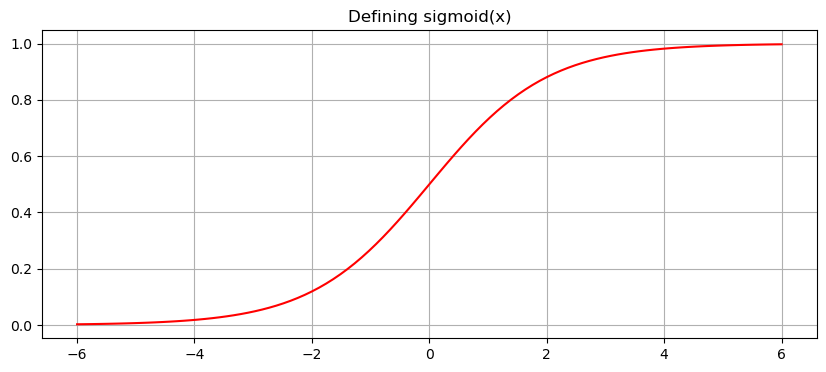

In [36]:
# Define sigmoid
def sigmoid(x):
    return 1/(1+np.exp(-(x)))

a = np.linspace(-6,6,100)
plt.figure(figsize=(10,4))
plt.plot(a, sigmoid(a),'r-')
plt.grid()
plt.title("Defining sigmoid(x)")
plt.show()

In [37]:
def f(w, xhat):
    return sigmoid(xhat.T@w)

def grad_f(w, xhat):
    return f(w, xhat)*(1-f(w, xhat))

In [38]:
def loss(w, X, Y):
    d,N = X.shape
#     return np.mean(np.square(f(w,X) - Y))/(2*N)
    return (1/2*N)*np.linalg.norm(f(w,X) - Y)**2

def grad_loss(w, X, Y):
    d,N = X.shape
    return (X@(f(w,X)*(1-f(w,X))*(f(w,X)-Y)))/N

In [39]:
def get_Xhat(X, N):
    Xhat = np.concatenate((np.ones((1,N)), X), axis=0)
    return Xhat

In [40]:
def normalize(y,C1,C2):
    y_normalized = y.copy()
    y_normalized[y_normalized==C1] = 0
    y_normalized[y_normalized==C2] = 1
    return y_normalized

In [41]:
def predict(w, X_test, threshold):
    y_pred = f(w, Xhat_test)
    y_pred[y_pred>threshold] = 1
    y_pred[y_pred<=threshold] = 0
    correct = np.sum(y_pred == y_test)
    accuracy = correct/y_test.shape[-1]
    return accuracy

In [42]:
def backtracking(f, grad_f, x, multivariate, D):
    """
    This function is a simple implementation of the backtracking algorithm for
    the GD (Gradient Descent) method.

    f: function. The function that we want to optimize.
    grad_f: function. The gradient of f(x).
    x: ndarray. The actual iterate x_k.
    multivariate: boolean. Indicate whether the function f
    is multivariate or not.
    """
    X, y = D
    y = y[0,:] # this is necessary to avoid problems with the shape during grad_loss computation
    if multivariate:
        norm = np.linalg.norm
    else:
        norm = np.abs

    alpha = 1
    c = 0.8
    tau = 0.25

    while f((x - alpha * grad_f(x, X, y)), X, y) > f(x, X, y) - c * alpha * norm(grad_f(x, X, y)) ** 2:
        alpha = tau * alpha

        if alpha < 1e-3:
            break
    return alpha


def GD(loss, grad_loss, w0, D, kmax, tolf, tolx, back_tracking=False, alpha=1, multivariate=True):
    """
    This function implements the Gradient Descent algorithm.
    """
    if multivariate:
        norm = np.linalg.norm
    else:
        norm = np.abs
    X,y = D
    y = y[0,:] # this is necessary to avoid problems with the shape during grad_loss computation
    # Initialize x_k
    w_k = w0

    # counter
    k = 0

    # Initialize the outputs
    w = [w0]
    f_val = [loss(w0,X,y)]
    grads = [grad_loss(w0,X,y)]
    err = [norm(grads[-1])]

    # Loop
    condition = True
    while condition:
        # Update alpha
        if back_tracking:
            alpha = backtracking(loss, grad_loss, w_k, multivariate, D)
        # Update x
        w_k = w_k - alpha * grad_loss(w_k,X,y)

        # Update outputs
        w.append(w_k)
        f_val.append(loss(w_k,X,y))
        grads.append(grad_loss(w_k,X,y))
        err.append(norm(grads[-1]))

        # check criteria
        condition1 = norm(grad_loss(w_k,X,y)) > (tolf * norm(grad_loss(w0,X,y)))
        condition2 = norm(w_k) > tolx
        condition3 = k < kmax
        condition = condition1 and condition2 and condition3

        # update k
        k += 1

    return w_k, k, np.array(w), np.array(f_val), np.array(grads), np.array(err)

## Stochastic Gradient Descent
You sample a batch of data, e.g. batch_size = 10 and you compute the values for batch_size instead of N.  
Then you start again with another batch until you've finished your data. This is an **epoch**.

In [43]:
def SGD(loss, grad_loss, w0, D, batch_size, n_epochs, learning_rate=1e-3):
    # Initialize the parameters w
    w = w0
        
    # Extract X and y from D
    X, y = D
    
    # Save in memory the length of X (and y)    They have the same dimension
    d,N = X.shape
    
    # We assume that batch_size divides N
    # Compute the number of batches per epoch
    
    n_batch_per_epoch = N // batch_size # integer division in case batch_size doesn't divide N
    
     # Initialize the output
    
    # a vector containing the value of l(w_k; D) after each epoch
    loss_history = np.zeros((n_epochs,))
    # a vector (w) containing the value of w_k for each iterate
    w_history = np.zeros((n_epochs, d))
    # a vector containing the value of grad_l(w_k; D) after each epoch
    grad_loss_history = np.zeros((n_epochs,d))
    # a vector containing the value of ||grad_l(w_k; D)||_2 after each epoch
    err = np.zeros((n_epochs,))
    
    # Iterate over the epochs
    for epoch in range(n_epochs):
        idx = np.arange(N)
        np.random.shuffle(idx)
        
        # Batch iteration
        for k in range(n_batch_per_epoch):
            X_batch = X[:, idx[k * batch_size : (k+1) * batch_size]]
            y_batch = y[0, idx[k * batch_size : (k+1) * batch_size]]
            
            B = (X_batch, y_batch) # it should not be necessary to define B.
            
            # Gradient descent update
            # The gradient has to be computed in B, 
            # it cannot be computed on the entire dataset as it will crash!!
            gradient = grad_loss(w, X_batch, y_batch)
            w = w - learning_rate * gradient
            
        w_history[epoch] = w 
        loss_history[epoch] = loss(w, X_batch, y_batch)  
        grad_loss_history[epoch] = gradient
        err[epoch] = np.linalg.norm(gradient)
        
        
    return w, w_history, loss_history, grad_loss_history, err

In [44]:
df = pd.read_csv('dataset/mnist-data.csv')
display(df.head())
data_array= df.to_numpy()
data_array = data_array.T
X_mid, y_mid = data_array[1:,:], data_array[:1, :]
X_mid.shape, y_mid.shape

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


((784, 42000), (1, 42000))

To test the script above, consider the MNIST dataset we used in the previous laboratories, and do the
following:
1. From the dataset, select only two digits. It would be great to let the user input the two digits to
select.
2. Do the same operation of the previous homework to obtain the training and test set from (X, Y ),
selecting the Ntrain you prefer.
3. Consider Lecture 11 on my website about the implementation of Logistic Regression for binary
classification https://www.evangelistadavide.com/teaching/logistic_regression2024/. It
has not been described in class, but it is equivalent to Linear Regression with a slightly modified
model. After carefully reading the post, implement a logistic regression classificator.

In [45]:
C1, C2 = 3,4

idx = (y_mid[0] == C1) | (y_mid[0] == C2)
X = X_mid[:, idx]
y = y_mid[:, idx]

Extracting random data points from the dataset:


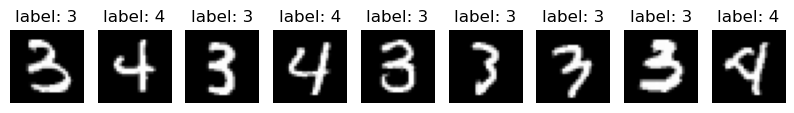

In [46]:
# Verifying the correctness of the chosen classes
i = np.random.choice(X.shape[1], size=9, replace=False)
fig, axes = plt.subplots(1,9, figsize=(10,10))
print("Extracting random data points from the dataset:")

for j, index in enumerate(i):
    image = X[:, index].reshape(28,28)
    axes[j].imshow(image, cmap="gray")
    axes[j].set_title(f"label: {y[0, index]}")
    axes[j].axis("off")

### Defining the train and test set
I normalize y in order to deal with probability of being 0 or 1, but just inside the train_test_split so y is not overridden

In [55]:
train_size = 0.5
N_train = int(train_size * y.shape[1])
X_train, y_train, X_test, y_test = train_test_split(X, normalize(y,C1,C2), N_train)

# Create Xhat
d,N = X_train.shape
Xhat_train = get_Xhat(X_train, N)

In [56]:
D_train = (Xhat_train, y_train)
n_epochs = 1000
batch_size = 100
learning_rate=1e-3
w0 = np.zeros((Xhat_train.shape[0]))

# Computing SGD
w, w_history, loss_history, grad_loss_history, err = SGD(loss, grad_loss, w0, D_train, batch_size, n_epochs, learning_rate)

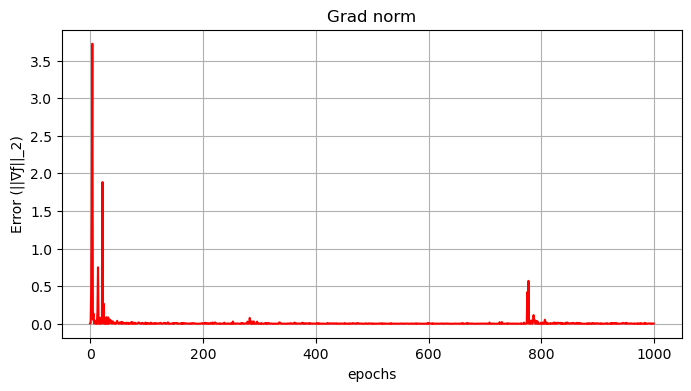

In [57]:
plot_error(range(err.shape[-1]),err, 'epochs')

In [58]:
d,N = X_test.shape
Xhat_test = get_Xhat(X_test, N)

accuracy = predict(w, Xhat_test, 0.5)

print(f"SGD: Accuracy of the polynomial classficator for digits {C1, C2}: {round(accuracy*100,2)}%")

SGD: Accuracy of the polynomial classficator for digits (3, 4): 99.31%


In [59]:
# Computing GD
kmax = 1_000
tolf = tolx = 1e-5
w_k, k, ws, f_vals, grads, errs = GD(loss, grad_loss, w0, D_train, kmax, tolf, tolx, back_tracking=False, alpha=1e-5, multivariate=True)

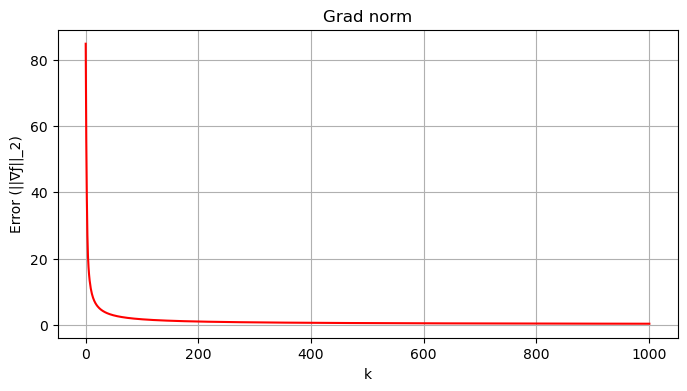

In [60]:
plot_error(range(errs.shape[-1]),errs, 'k')

In [61]:
d,N = X_test.shape
Xhat_test = get_Xhat(X_test, N)
accuracy_GD = predict(w_k, Xhat_test, 0.5)

print(f"GD: Accuracy of the polynomial classficator for digits {C1, C2}: {round(accuracy_GD*100,2)}%")

GD: Accuracy of the polynomial classficator for digits (3, 4): 99.55%


## Testing the accuracy of the Logistic Regression Classifier varying the digits

In [66]:
train_size = 0.5

n_epochs = 100
batch_size = 100
learning_rate=1e-3

kmax = 1_00
tolf = tolx = 1e-5

C_done = []

for C1 in range(1,10):
    C_done.append(C1)
    for C2 in range(1,10):
        if C2 in C_done:
            continue
        print(f'Comparing digits {C1,C2}')
        idx = (y_mid[0] == C1) | (y_mid[0] == C2)
        X = X_mid[:, idx]
        y = y_mid[:, idx]
        
        N_train = int(train_size * y.shape[1])
        X_train, y_train, X_test, y_test = train_test_split(X, normalize(y,C1,C2), N_train)

        # Create Xhat
        d,N = X_train.shape
        Xhat_train = get_Xhat(X_train, N)
        
        D_train = (Xhat_train, y_train)
        w0 = np.zeros((Xhat_train.shape[0]))

        # Computing SGD
        w, w_history, loss_history, grad_loss_history, err = SGD(loss, grad_loss, w0, D_train, batch_size, n_epochs, learning_rate)
        
        d,N = X_test.shape
        Xhat_test = get_Xhat(X_test, N)

        accuracy = predict(w, Xhat_test, 0.5)

        print(f"    SGD: Accuracy of the polynomial classficator: {round(accuracy*100,2)}%")
        
        # Computing GD
        w_k, k, ws, f_vals, grads, errs = GD(loss, grad_loss, w0, D_train, kmax, tolf, tolx, back_tracking=False, alpha=1e-5, multivariate=True)
        
        d,N = X_test.shape
        Xhat_test = get_Xhat(X_test, N)
        accuracy_GD = predict(w_k, Xhat_test, 0.5)

        print(f"    GD: Accuracy of the polynomial classficator: {round(accuracy_GD*100,2)}%")

Comparing digits (1, 2)
    SGD: Accuracy of the polynomial classficator: 99.28%
    GD: Accuracy of the polynomial classficator: 98.8%
Comparing digits (1, 3)
    SGD: Accuracy of the polynomial classficator: 98.94%
    GD: Accuracy of the polynomial classficator: 98.63%
Comparing digits (1, 4)
    SGD: Accuracy of the polynomial classficator: 99.25%
    GD: Accuracy of the polynomial classficator: 99.27%
Comparing digits (1, 5)
    SGD: Accuracy of the polynomial classficator: 99.46%
    GD: Accuracy of the polynomial classficator: 98.8%
Comparing digits (1, 6)
    SGD: Accuracy of the polynomial classficator: 99.59%
    GD: Accuracy of the polynomial classficator: 99.48%
Comparing digits (1, 7)
    SGD: Accuracy of the polynomial classficator: 99.19%
    GD: Accuracy of the polynomial classficator: 98.79%
Comparing digits (1, 8)
    SGD: Accuracy of the polynomial classficator: 98.06%
    GD: Accuracy of the polynomial classficator: 97.53%
Comparing digits (1, 9)
    SGD: Accuracy o